In [ ]:
!pip install nltk
!pip install transformers
!pip install torch
!pip install textblob


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

plt.style.use('ggplot')

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('vader_lexicon')

import torch
import transformers
import json
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel, RobertaTokenizer
import logging
logging.basicConfig(level=logging.ERROR)

import ssl
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package punkt to /home/shabad/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/shabad/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /home/shabad/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /home/shabad/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/shabad/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
/home/shabad/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import dask.dataframe as dd
import pandas as pd
import gzip
import json


# Loading Dataset
file_path = 'Clothing_Shoes_and_Jewelry_5.json.gz'


def read_json_gz_in_chunks(file_path, chunk_size=100000): #    1000000):
    with gzip.open(file_path, 'rt', encoding='utf-8') as f:
        chunk = []
        for i, line in enumerate(f):
            chunk.append(json.loads(line))
            if (i + 1) % chunk_size == 0:
                yield pd.DataFrame(chunk)
                break
        # if chunk:
        #     yield pd.DataFrame(chunk)
        # if 

# Initializing an empty DataFrame to concatenate chunks
df = pd.DataFrame()

# Read and process in chunks
for chunk_df in read_json_gz_in_chunks(file_path):
    df = pd.concat([df, chunk_df], ignore_index=True)

del(chunk_df)
df.head()

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image
0,5.0,2,True,"05 4, 2014",A2IC3NZN488KWK,0871167042,{'Format:': ' Paperback'},Ruby Tulip,"This book has beautiful photos, good and under...",Unique designs,1399161600,NaN
1,5.0,NaN,True,"03 31, 2014",A30FG02C424EJ5,0871167042,{'Format:': ' Paperback'},NWCancerBaby,Loved their approach in this book and that it ...,Great Book,1396224000,NaN
2,5.0,NaN,True,"05 30, 2015",A2G9GWQEWWNQUB,0871167042,{'Format:': ' Paperback'},Pamelarenee,great,Five Stars,1432944000,NaN
3,5.0,NaN,True,"02 21, 2015",A3NI5OGW35SLY2,0871167042,{'Format:': ' Paperback'},Gail,"Always love the way Eva thinks, and there are ...",Great Book!,1424476800,NaN
4,5.0,NaN,True,"01 21, 2015",A1OPRA4NE56EV6,0871167042,{'Format:': ' Paperback'},carol a inman,Nice patterns,Five Stars,1421798400,NaN


In [18]:
df.shape

(10000, 12)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/shabad/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Average sentiment (TextBlob): 0.31759062516804015
Average sentiment (VADER): 0.5343927829999999


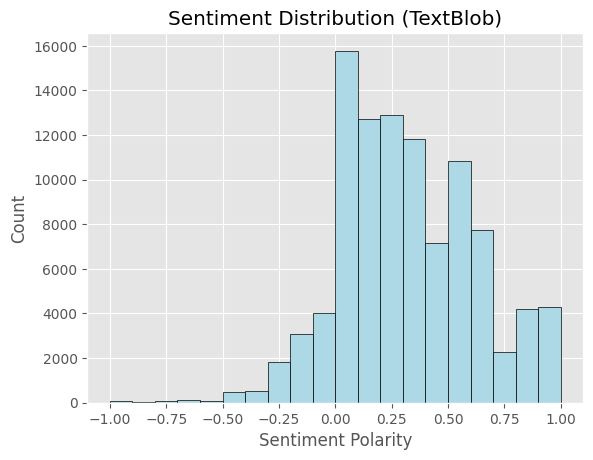

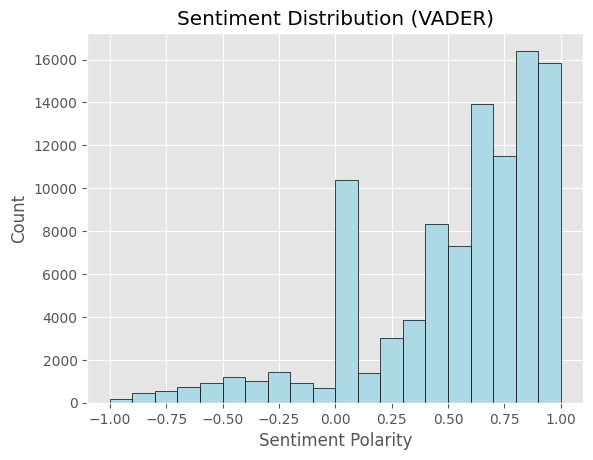

In [3]:
# Disable SSL certificate verification (not recommended for production use)
ssl._create_default_https_context = ssl._create_unverified_context

# Download the VADER lexicon data
nltk.download('vader_lexicon')

# Sentiment analysis using TextBlob
def analyze_sentiment_textblob(text):
    if isinstance(text, str):
        analysis = TextBlob(text)
        return analysis.sentiment.polarity
    else:
        return 0.0

# Sentiment analysis using VADER (NLTK)
def analyze_sentiment_vader(text):
    if isinstance(text, str):
        sid = SentimentIntensityAnalyzer()
        sentiment_scores = sid.polarity_scores(text)
        return sentiment_scores['compound']
    else:
        return 0.0


# Preprocess review text
df['reviewText'] = df['reviewText'].str.lower()
df['reviewText'] = df['reviewText'].str.replace('[^\w\s]', '')

# Analyze sentiment using TextBlob and VADER
df['sentiment_textblob'] = df['reviewText'].apply(analyze_sentiment_textblob)
df['sentiment_vader'] = df['reviewText'].apply(analyze_sentiment_vader)

# Analyze sentiment distribution
average_sentiment_textblob = df['sentiment_textblob'].mean()
average_sentiment_vader = df['sentiment_vader'].mean()

print(f'Average sentiment (TextBlob): {average_sentiment_textblob}')
print(f'Average sentiment (VADER): {average_sentiment_vader}')

# Identify positive and negative reviews
positive_reviews_textblob = df[df['sentiment_textblob'] > 0]
negative_reviews_textblob = df[df['sentiment_textblob'] < 0]

positive_reviews_vader = df[df['sentiment_vader'] > 0]
negative_reviews_vader = df[df['sentiment_vader'] < 0]

# Visualize sentiment distribution
plt.hist(df['sentiment_textblob'], bins=20, range=(-1, 1), color='lightblue', edgecolor='black')
plt.title('Sentiment Distribution (TextBlob)')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Count')
plt.show()

plt.hist(df['sentiment_vader'], bins=20, range=(-1, 1), color='lightblue', edgecolor='black')
plt.title('Sentiment Distribution (VADER)')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Count')
plt.show()

In [4]:
reviews_df = pd.DataFrame(df)

reviews_df.insert(0, 'Id', range(1, len(reviews_df) + 1))

# Display the updated DataFrame


# Display the shape and the first few rows of the DataFrame
print(reviews_df.shape)
print(reviews_df.head())

(100000, 15)
   Id  overall vote  verified   reviewTime      reviewerID        asin  \
0   1      5.0    2      True   05 4, 2014  A2IC3NZN488KWK  0871167042   
1   2      5.0  NaN      True  03 31, 2014  A30FG02C424EJ5  0871167042   
2   3      5.0  NaN      True  05 30, 2015  A2G9GWQEWWNQUB  0871167042   
3   4      5.0  NaN      True  02 21, 2015  A3NI5OGW35SLY2  0871167042   
4   5      5.0  NaN      True  01 21, 2015  A1OPRA4NE56EV6  0871167042   

                       style   reviewerName  \
0  {'Format:': ' Paperback'}     Ruby Tulip   
1  {'Format:': ' Paperback'}   NWCancerBaby   
2  {'Format:': ' Paperback'}    Pamelarenee   
3  {'Format:': ' Paperback'}           Gail   
4  {'Format:': ' Paperback'}  carol a inman   

                                          reviewText         summary  \
0  this book has beautiful photos, good and under...  Unique designs   
1  loved their approach in this book and that it ...      Great Book   
2                                          

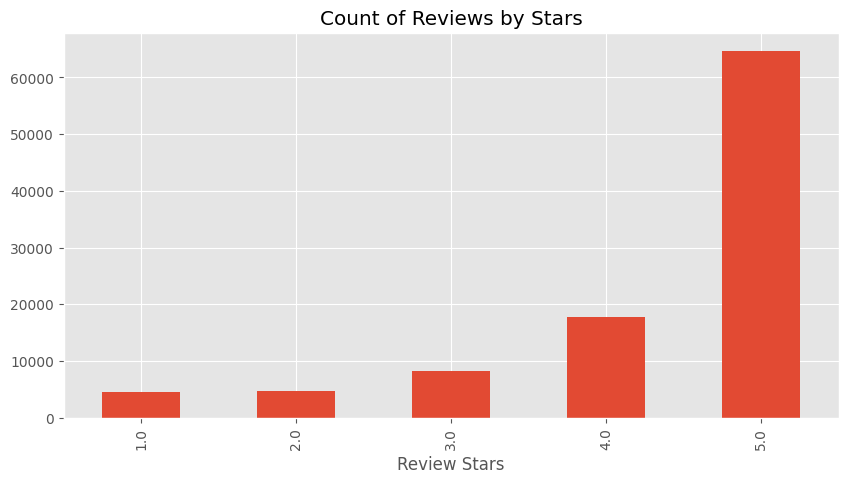

In [13]:
ax = reviews_df['overall'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

In [14]:
example = reviews_df['reviewText'][50]
print(example)

great for a meeting for several child care centers in the inner city.


In [15]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['great',
 'for',
 'a',
 'meeting',
 'for',
 'several',
 'child',
 'care',
 'centers',
 'in']

In [16]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('great', 'JJ'),
 ('for', 'IN'),
 ('a', 'DT'),
 ('meeting', 'NN'),
 ('for', 'IN'),
 ('several', 'JJ'),
 ('child', 'NN'),
 ('care', 'NN'),
 ('centers', 'NNS'),
 ('in', 'IN')]

In [17]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  great/JJ
  for/IN
  a/DT
  meeting/NN
  for/IN
  several/JJ
  child/NN
  care/NN
  centers/NNS
  in/IN
  the/DT
  inner/JJ
  city/NN
  ./.)


In [5]:
# VADER
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [19]:
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [20]:
sia.polarity_scores('This is the worst thing ever.')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [21]:
sia.polarity_scores(example)

{'neg': 0.0, 'neu': 0.578, 'pos': 0.422, 'compound': 0.8074}

In [6]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [7]:
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tqdm import tqdm

# Assuming your DataFrame is named 'df'
reviews_df['reviewText'] = reviews_df['reviewText'].fillna('')  # Replace NaN values with empty strings

# Initialize the SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Create an empty dictionary to store the results
res = {}

# Loop through the DataFrame
for i, row in tqdm(reviews_df.iterrows(), total=len(reviews_df)):
    text = str(row['reviewText'])  # Convert the text to a string
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)


100%|██████████| 100000/100000 [00:27<00:00, 3662.76it/s]


In [8]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
# Specify the common column to merge on
vaders = vaders.merge(reviews_df, on='Id', how='left')

In [25]:
vaders.head()

,Id,neg,neu,pos,compound,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image,sentiment_textblob,sentiment_vader
0,1,0.0,0.706,0.294,0.8622,5.0,2,True,"05 4, 2014",A2IC3NZN488KWK,0871167042,{'Format:': ' Paperback'},Ruby Tulip,"this book has beautiful photos, good and under...",Unique designs,1399161600,NaN,0.442000,0.8622
1,2,0.0,0.676,0.324,0.8625,5.0,NaN,True,"03 31, 2014",A30FG02C424EJ5,0871167042,{'Format:': ' Paperback'},NWCancerBaby,loved their approach in this book and that it ...,Great Book,1396224000,NaN,0.544444,0.8625
2,3,0.0,0.000,1.000,0.6249,5.0,NaN,True,"05 30, 2015",A2G9GWQEWWNQUB,0871167042,{'Format:': ' Paperback'},Pamelarenee,great,Five Stars,1432944000,NaN,0.800000,0.6249
3,4,0.0,0.592,0.408,0.9081,5.0,NaN,True,"02 21, 2015",A3NI5OGW35SLY2,0871167042,{'Format:': ' Paperback'},Gail,"always love the way eva thinks, and there are ...",Great Book!,1424476800,NaN,0.366667,0.9081
4,5,0.0,0.263,0.737,0.4215,5.0,NaN,True,"01 21, 2015",A1OPRA4NE56EV6,0871167042,{'Format:': ' Paperback'},carol a inman,nice patterns,Five Stars,1421798400,NaN,0.600000,0.4215


In [29]:
lowest_vader_score = vaders['compound'].min()
print(f"Lowest VADER 'compound' score: {lowest_vader_score}")

Lowest VADER 'compound' score: -0.9957


Text(0.5, 1.0, 'Compund Score by Amazon Star Review')

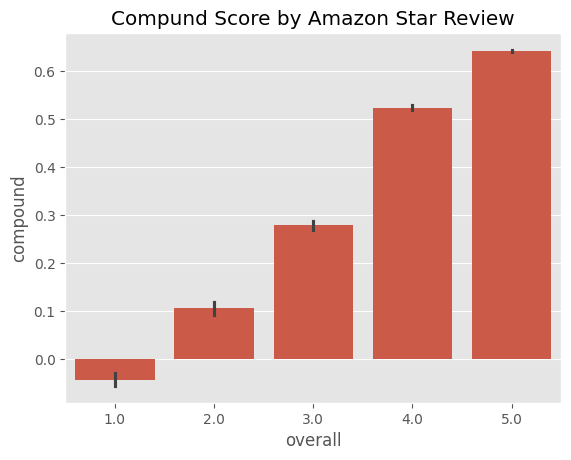

In [30]:
ax = sns.barplot(data=vaders, x='overall', y='compound')
ax.set_title('Compund Score by Amazon Star Review')
plt.show()

<Axes: xlabel='overall', ylabel='pos'>

<Axes: xlabel='overall', ylabel='neu'>

<Axes: xlabel='overall', ylabel='neg'>

Text(0.5, 1.0, 'Positive')

Text(0.5, 1.0, 'Neutral')

Text(0.5, 1.0, 'Negative')

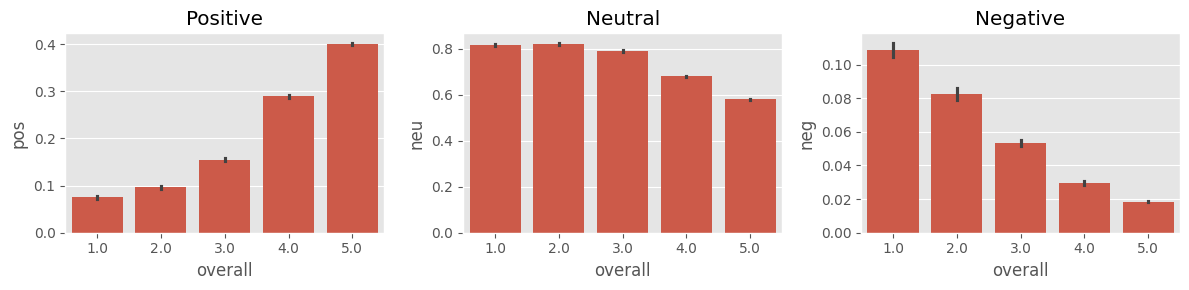

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='overall', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='overall', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='overall', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

In [10]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification


MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

/home/shabad/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [12]:
from scipy.special import softmax

# Run for Roberta Model
example = "This is a sample text for sentiment analysis using RoBERTa."

encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.024569537, 'roberta_neu': 0.9146817, 'roberta_pos': 0.06074872}


In [13]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [14]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(reviews_df, how='left')

In [15]:
res = {}
for i, row in tqdm(reviews_df.iterrows(), total=len(reviews_df)):
    try:
        text = row['reviewText']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  1%|          | 1005/100000 [01:53<11:22:51,  2.42it/s]

Broke for id 1004


  2%|▏         | 1813/100000 [03:04<5:32:14,  4.93it/s] 

Broke for id 1814


  4%|▍         | 3914/100000 [05:47<4:28:42,  5.96it/s]

Broke for id 3912
Broke for id 3913


  7%|▋         | 6803/100000 [09:46<1:59:53, 12.96it/s]

Broke for id 6801


  8%|▊         | 7531/100000 [10:43<1:47:06, 14.39it/s]

Broke for id 7529


  9%|▉         | 9097/100000 [12:47<1:50:44, 13.68it/s]

Broke for id 9095
Broke for id 9096


  9%|▉         | 9483/100000 [13:19<1:44:40, 14.41it/s]

Broke for id 9481


 10%|▉         | 9977/100000 [14:16<3:25:53,  7.29it/s]

Broke for id 9976


 11%|█         | 11094/100000 [16:14<2:11:39, 11.25it/s]

Broke for id 11092


 13%|█▎        | 13469/100000 [19:48<2:36:35,  9.21it/s]

Broke for id 13469


 14%|█▎        | 13533/100000 [19:56<2:19:57, 10.30it/s]

Broke for id 13532


 15%|█▍        | 14831/100000 [21:46<2:05:00, 11.36it/s]


KeyboardInterrupt: 

KeyError: 'vader_neg'

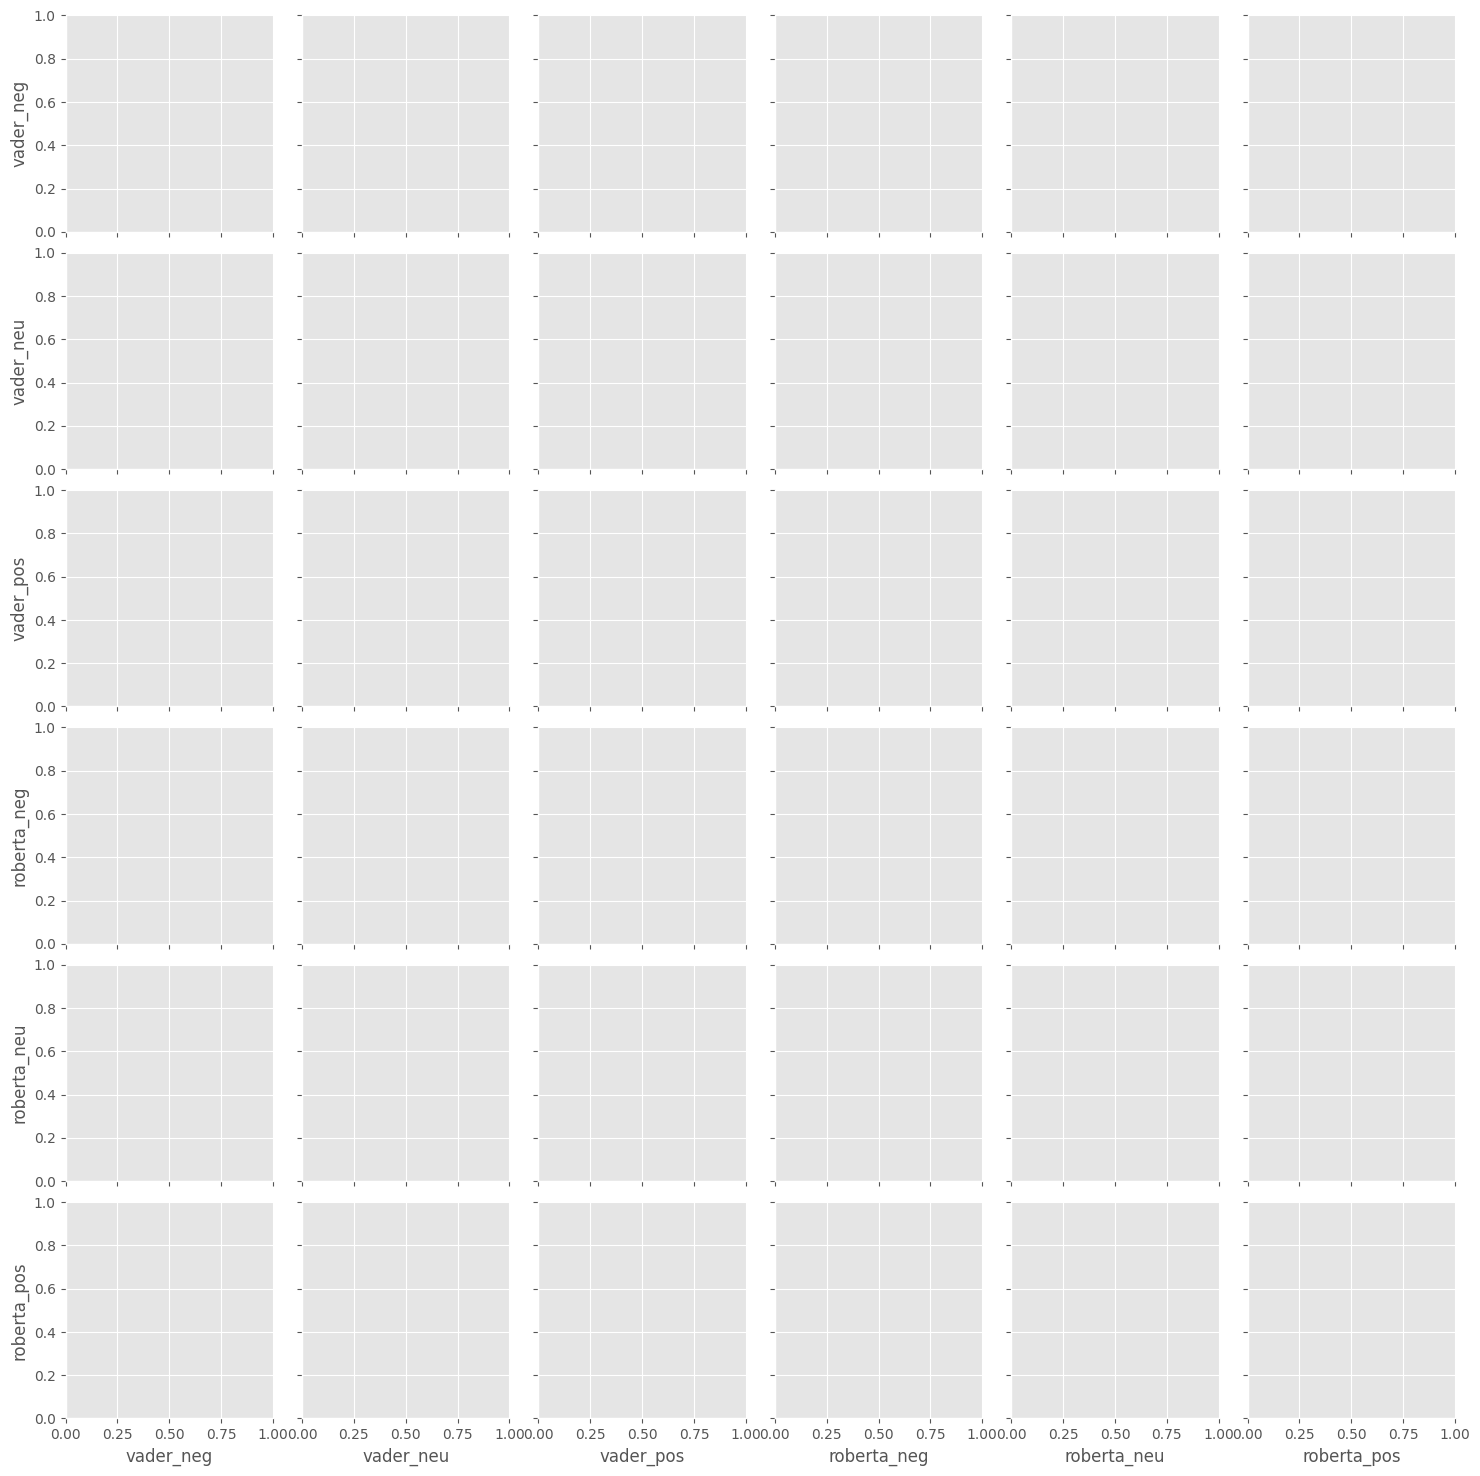

In [16]:
import seaborn as sns

sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='overall',
            palette='tab10')
plt.show()